In [15]:
import pennylane as qml
from pennylane import numpy as np

import numpy as np_

import matplotlib.pyplot as plt


# == Hamiltonain setup == 
coeff = [-0.5]
obs = [qml.PauliZ(0)]
Hamiltonian = qml.Hamiltonian(coeff, obs)

dev = qml.device("default.mixed", wires = 1)

Tau, Gamma_ps, Gamma_Dephase = 0, 0, 0

# == Relation between kraus_gamma vs tau
def Dephase_factor(tau):
    global Gamma_Dephase
    
    Cal_dephase = 1 - np.exp(-2 * tau)
    Gamma_Dephase = Cal_dephase

def Dephase_factor_Get_tau(gamma):
    global Tau 
    
    Cal_tau = -np.log( np.sqrt(1 - gamma))
    Tau = Cal_tau

$$
\rho_{After_Hadamard} = 

\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

where,
\quad \gamma = 
1 - e^{-2 \tau}
$$


$$ 
e^{-t} = \sqrt{1 - \gamma}

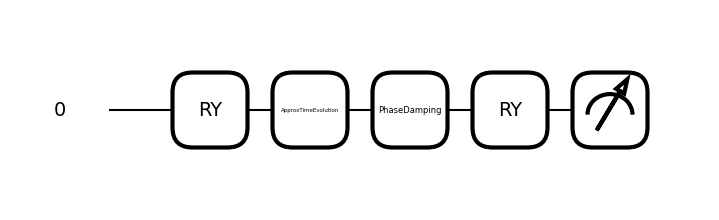

In [16]:
# == Generate circuit ==

# Stage_1: Generate dephase
@qml.qnode(dev)
def Dephase_circuit(phi):
    qml.RY(np.pi/2, wires=0)
    
    # Time_evo t fixed as -phi/2
    qml.ApproxTimeEvolution(Hamiltonian, phi, 1)
    
    qml.PhaseDamping(Gamma_Dephase, wires = 0)
    
    qml.RY(np.pi/2, wires=0)

    return qml.density_matrix(wires=0)

# Stage_2: Post-selection
@qml.qnode(dev)
def Post_selection(phi):
    rho_dephase = Dephase_circuit(phi)
    Kraus_oper = np.array([ [np.sqrt(1-Gamma_ps), 0], [0, 1] ])
    
    Numerator = Kraus_oper @ rho_dephase @ Kraus_oper.conj().T
    Denominator = np.trace(Kraus_oper @ rho_dephase @ Kraus_oper.conj().T)
    
    rho_ps =  Numerator / Denominator 
    
    qml.QubitDensityMatrix(rho_ps, wires=0)
    
    return qml.density_matrix(wires=0)

fig, ax = qml.draw_mpl(Dephase_circuit)(1)

In [17]:
def Plot_dephase(Plot_range, Step_size, Gamma_ps_select, tau):
    
    # Searching Range
    Sweep_Range = np.arange(Plot_range[0], Plot_range[1], Step_size)
    
    Num_CFI = len(tau)
    CFI = np_.zeros((Num_CFI, len(Sweep_Range)))
    
    for i in range(Num_CFI):
        for j in range(len(Sweep_Range)):
            
            # Set Dephase_gamma
            global Gamma_ps
            
            Gamma_ps = Gamma_ps_select
            Dephase_factor(tau[i])
            
            Temp = qml.qinfo.classical_fisher(Dephase_circuit)(Sweep_Range[j])
        
            # Casting to np.array
            CFI[i][j] = np.array(Temp[0], requires_grad = 'False')
        
            Temp = np.zeros(1)  
            
    for i in range(Num_CFI):
        plt.plot(Sweep_Range, CFI[i][:], label = f'tau = {tau[i]}')
    
    plt.title('CFI with Dephase')
    plt.xlabel('Time')
    plt.ylabel('CFI')
    plt.legend()
    plt.grid() 

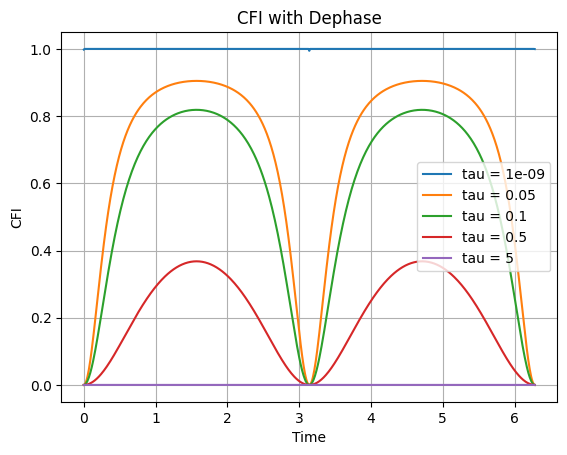

In [18]:
BOUND = np_.array([ 1e-3, np.pi * 2 + 1e-3])
Step_size_in = 1e-2
Tau_in = 0.000000001, 0.05, 0.1, 0.5, 5
Gamma_in = 0, 0.8

Plot_dephase(BOUND, Step_size_in, Gamma_in[0], Tau_in)

In [19]:
def Plot_dephase_PS(Plot_range, Step_size, Gamma_ps_select, tau):
    
    # Searching Range
    Sweep_Range = np.arange(Plot_range[0], Plot_range[1], Step_size)
    
    Num_CFI = len(tau)
    CFI = np_.zeros((Num_CFI, len(Sweep_Range)))
    
    for i in range(Num_CFI):
        for j in range(len(Sweep_Range)):
            
            # Set Dephase_gamma
            global Gamma_ps
            
            Gamma_ps = Gamma_ps_select
            Dephase_factor(tau[i])
            
            Temp = qml.qinfo.classical_fisher(Post_selection)(Sweep_Range[j])
        
            # Casting to np.array
            CFI[i][j] = np.array(Temp[0], requires_grad = 'False')
        
            Temp = np.zeros(1)  
            
    for i in range(Num_CFI):
        plt.plot(Sweep_Range, CFI[i][:], label = f'tau = {tau[i]}')
    
    plt.title('CFI with Dephase')
    plt.xlabel('Time')
    plt.ylabel('CFI')
    plt.legend()
    plt.grid() 

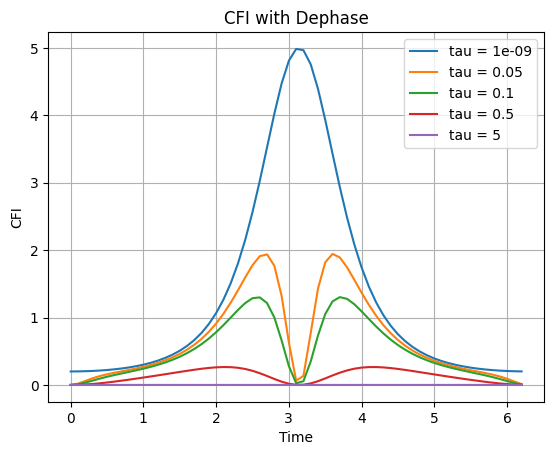

In [21]:
Gamma_in = 0, 0.8

Plot_dephase_PS(BOUND, Step_size_in, Gamma_in[1], Tau_in)